<a href="https://cognitiveclass.ai"><img src = "https://ibm.box.com/shared/static/9gegpsmnsoo25ikkbl4qzlvlyjbgxs5x.png" width = 400> </a>



 # Capstone Project-Choose a Restaurant Location

Where to open a restaurant in Toronto 



## 1) Introduction

There are many different kinds of restaurants and catering services. Whether you are interested in starting a café, a bar, family-style restaurant or event catering business, you will be part of the food services industry.
For a restaurant, location is very important. Since location will decide how many potential customers will be and what price they will pay.
We will use Foursquare data to find these two things. In Foursquare Places API, we can Get Details of a Venue. Here we try to find the best venue location in Toronto to open a restaurant
The result may be useful for people to open their own restaurant, or may lend some thoughts to other business location finding.

## 2) Data

In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geopy-1.18.1               |             py_0          51 KB  conda-forge
    geographiclib-1.49         |             py_0          32 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          84 KB

The following NEW packages will be INSTALLED:

    geographiclib: 1.49-py_0   conda-forge
    geopy:         1.18.1-py_0 conda-forge


geopy-1.18.1         | 51 KB     | ##################################### | 100% 
geographiclib-1.49   | 32 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Solving environment: done

## Package Plan ##

  envi

# Request and get data from wikipedia

In [45]:
from bs4 import BeautifulSoup
mysource = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M").text
soup = BeautifulSoup(mysource, 'lxml')
table = soup.find_all('table', {'class':'wikitable sortable'})

# Create the data

In [46]:
Toronto_table = pd.read_html(str(table[0]), index_col=None, header=0)[0]
Toronto_table.head()

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


In [47]:
type(Toronto_table)

pandas.core.frame.DataFrame

# data cleaning

In [48]:
#  1. Only process the cells that have an assigned borough.
Toronto_table = Toronto_table[Toronto_table.Borough != 'Not assigned']
Toronto_table.head(10)

,Postcode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights
7,M6A,North York,Lawrence Manor
8,M7A,Queen's Park,Not assigned
10,M9A,Etobicoke,Islington Avenue
11,M1B,Scarborough,Rouge
12,M1B,Scarborough,Malvern


In [49]:
# 2. If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough.
Toronto_table.loc[Toronto_table.Neighbourhood == 'Not assigned', 'Neighbourhood'] = Toronto_table.Borough

Toronto_table.head()

,Postcode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights


In [50]:

# 3. Group Neghborhood by Postcode
Toronto_tableN = Toronto_table.groupby(['Postcode','Borough'])['Neighbourhood'].agg(lambda x: ','.join(set(x))).reset_index()

# My data frame

In [51]:
Toronto_tableN.head()

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Malvern,Rouge"
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union"
2,M1E,Scarborough,"Morningside,Guildwood,West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [52]:
Toronto_tableN.shape

(103, 3)

# The latitude and the longitude coordinates of each neighborhood.

In [53]:
Geol = pd.read_csv('http://cocl.us/Geospatial_data/Geospatial_Coordinates.csv')
Geol.head(10)

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476
5,M1J,43.744734,-79.239476
6,M1K,43.727929,-79.262029
7,M1L,43.711112,-79.284577
8,M1M,43.716316,-79.239476
9,M1N,43.692657,-79.264848


In [54]:
Geol.rename(columns ={'Postal Code':'Postcode'}, inplace = True) 
Geol.head(10)

,Postcode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476
5,M1J,43.744734,-79.239476
6,M1K,43.727929,-79.262029
7,M1L,43.711112,-79.284577
8,M1M,43.716316,-79.239476
9,M1N,43.692657,-79.264848


Add the two tables 

In [55]:
Toronto_tableN.reset_index(drop=True, inplace=True)
Geol.reset_index(drop=True, inplace=True)
Toronto_tableN = Toronto_tableN.astype(str)
Geol = Geol.astype(str)
Toronto_tableN = pd.merge(Toronto_tableN, Geol, on = 'Postcode')
Toronto_tableN['Latitude'] = pd.to_numeric(Toronto_tableN['Latitude'], errors='coerce')
Toronto_tableN['Longitude'] = pd.to_numeric(Toronto_tableN['Longitude'], errors='coerce')
Toronto_tableN.head(10)

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern,Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Morningside,Guildwood,West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"Ionview,Kennedy Park,East Birchmount Park",43.727929,-79.262029
7,M1L,Scarborough,"Golden Mile,Clairlea,Oakridge",43.711112,-79.284577
8,M1M,Scarborough,"Cliffside,Scarborough Village West,Cliffcrest",43.716316,-79.239476
9,M1N,Scarborough,"Cliffside West,Birch Cliff",43.692657,-79.264848


# Explore the neighborhoods in Toronto.

In [56]:
c_lat = Toronto_tableN.Latitude.mean()
c_lon = Toronto_tableN.Longitude.mean()
c_lat,c_lon

(43.70460773398059, -79.39715291165048)

In [57]:
from sklearn.cluster import KMeans
import folium # map rendering library

kclusters = 5
toronto_grouped_clustering = Toronto_tableN.drop(['Neighbourhood','Borough','Postcode'], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

In [58]:
import matplotlib.cm as cm
import matplotlib.colors as colors

Toronto_tableN['Cluster Labels'] = kmeans.labels_
map_clusters = folium.Map(location=[c_lat, c_lon], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Toronto_tableN['Latitude'], Toronto_tableN['Longitude'], Toronto_tableN['Neighbourhood'], Toronto_tableN['Cluster Labels']):
    label = folium.Popup(str(poi) + ' (Cluster: ' + str(cluster) + ')', parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

In [59]:
map_clusters


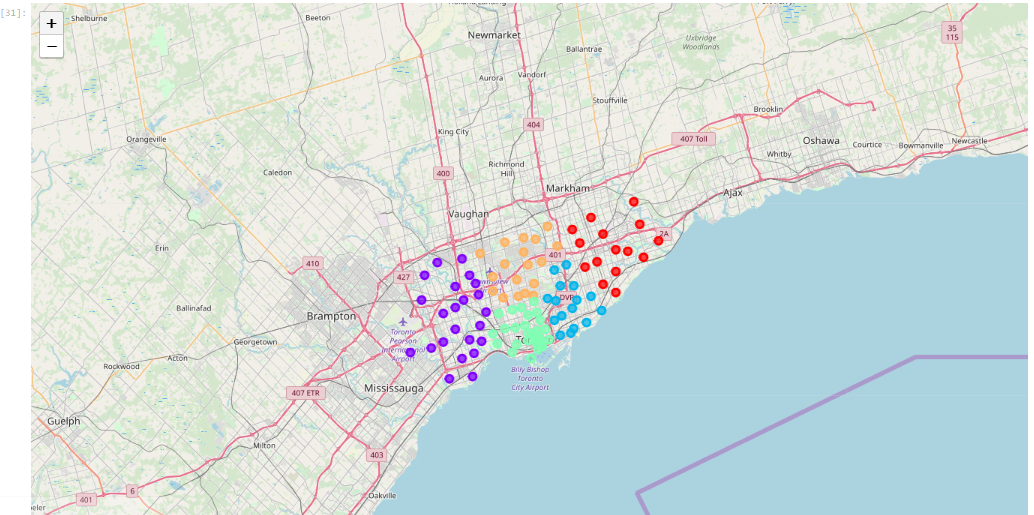

In [75]:
#  in case you can't see this because you are using Chrome or an outdated browser

from IPython.display import display, Image
display(Image(filename='map.PNG'))

In [60]:
CLIENT_ID = 'AFP3I0GSB4TMQU4KWBOTJWE24H30YJQYBBL1V5C2BQT3NNVK' # your Foursquare ID
CLIENT_SECRET = 'GQ25FHXLBOOWIRTJMGNRWVFB33SZXQ35VHHBLGVMK2H5ARQE' # your Foursquare Secret
VERSION = '20181227' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: AFP3I0GSB4TMQU4KWBOTJWE24H30YJQYBBL1V5C2BQT3NNVK
CLIENT_SECRET:GQ25FHXLBOOWIRTJMGNRWVFB33SZXQ35VHHBLGVMK2H5ARQE


# Using a radius of 5km to identify for nearby venues

In [61]:
def getNearbyVenues(names, latitudes, longitudes, radius=5000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Postcode', 
                  'Postcode Latitude', 
                  'Postcode Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [62]:
#radius = 5000
LIMIT = 100
# type your answer here
canada_venues = getNearbyVenues(names=Toronto_tableN['Postcode'],
                                   latitudes=Toronto_tableN['Latitude'],
                                   longitudes=Toronto_tableN['Longitude']
                                  )

M1B
M1C
M1E
M1G
M1H
M1J
M1K
M1L
M1M
M1N
M1P
M1R
M1S
M1T
M1V
M1W
M1X
M2H
M2J
M2K
M2L
M2M
M2N
M2P
M2R
M3A
M3B
M3C
M3H
M3J
M3K
M3L
M3M
M3N
M4A
M4B
M4C
M4E
M4G
M4H
M4J
M4K
M4L
M4M
M4N
M4P
M4R
M4S
M4T
M4V
M4W
M4X
M4Y
M5A
M5B
M5C
M5E
M5G
M5H
M5J
M5K
M5L
M5M
M5N
M5P
M5R
M5S
M5T
M5V
M5W
M5X
M6A
M6B
M6C
M6E
M6G
M6H
M6J
M6K
M6L
M6M
M6N
M6P
M6R
M6S
M7A
M7R
M7Y
M8V
M8W
M8X
M8Y
M8Z
M9A
M9B
M9C
M9L
M9M
M9N
M9P
M9R
M9V
M9W


In [63]:
canada_venues.groupby('Postcode').count()

,Postcode Latitude,Postcode Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Postcode,,,,,,
M1B,100,100,100,100,100,100
M1C,81,81,81,81,81,81
M1E,100,100,100,100,100,100
M1G,100,100,100,100,100,100
M1H,100,100,100,100,100,100
M1J,100,100,100,100,100,100
M1K,100,100,100,100,100,100
M1L,100,100,100,100,100,100
M1M,100,100,100,100,100,100


In [64]:
print('There are {} uniques categories.'.format(len(canada_venues['Venue Category'].unique())))

There are 255 uniques categories.


# 5. Explore Trending Venues

In [65]:
# ANALYSIS

# one hot encoding
toronto_onehot = pd.get_dummies(canada_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Postcode'] = canada_venues['Postcode'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Postcode,ATM,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Automotive Shop,BBQ Joint,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Beach,Beer Bar,Beer Store,Big Box Store,Bike Shop,Bistro,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Station,Butcher,Café,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Casino,Castle,Caucasian Restaurant,Chinese Restaurant,Chocolate Shop,Church,Churrascaria,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Rec Center,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Eye Doctor,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gastropub,General Entertainment,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health Food Store,High School,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hong Kong Restaurant,Hookah Bar,Hostel,Hotel,Hotpot Restaurant,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kebab Restaurant,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Liquor Store,Malay Restaurant,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music School,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoor Supply Store,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Pub,Racecourse,Racetrack,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Restaurant,Rock Climbing Spot,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Seafood Restaurant,Shoe Repair,Shoe Store,Shopping Mall,Shopping Plaza,Skating Rink,Ski Chalet,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Stables,Steakhouse,Street Art,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Stadium,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Track,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,M1B,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [66]:

toronto_grouped = toronto_onehot.groupby('Postcode').mean().reset_index()
toronto_grouped.head()

,Postcode,ATM,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Automotive Shop,BBQ Joint,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Beach,Beer Bar,Beer Store,Big Box Store,Bike Shop,Bistro,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Station,Butcher,Café,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Casino,Castle,Caucasian Restaurant,Chinese Restaurant,Chocolate Shop,Church,Churrascaria,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Rec Center,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Eye Doctor,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gastropub,General Entertainment,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health Food Store,High School,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hong Kong Restaurant,Hookah Bar,Hostel,Hotel,Hotpot Restaurant,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kebab Restaurant,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Liquor Store,Malay Restaurant,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music School,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoor Supply Store,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Pub,Racecourse,Racetrack,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Restaurant,Rock Climbing Spot,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Seafood Restaurant,Shoe Repair,Shoe Store,Shopping Mall,Shopping Plaza,Skating Rink,Ski Chalet,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Stables,Steakhouse,Street Art,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Stadium,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Track,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,M1B,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.020000,0.0,0.0,0.0,0.00,0.0,0.010000,0.030000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.020000,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.030000,0.0,0.0,0.0,0.0,0.0,0.0,0.030000,0.0,0.0,0.00,0.0,0.0,0.010000,0.0,0.00,0.020000,0.0,0.0,0.0,0.030000,0.01,0.0,0.0,0.0,0.0,0.00,0.0,0.11000,0.0,0.0,0.0,0.0,0.0,0.0,0.0

 # Identifying the top 10 venue by Borough (i.e. Postcode) 

In [67]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [68]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Postcode']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Postcode'] = toronto_grouped['Postcode']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Postcode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Coffee Shop,Zoo Exhibit,Sandwich Place,Pharmacy,Fast Food Restaurant,Pizza Place,Park,Breakfast Spot,Fried Chicken Joint,Burger Joint
1,M1C,Zoo Exhibit,Coffee Shop,Park,Breakfast Spot,Pizza Place,Sandwich Place,Fast Food Restaurant,Beer Store,Smoothie Shop,Zoo
2,M1E,Coffee Shop,Park,Sandwich Place,Bank,Pharmacy,Indian Restaurant,Beer Store,Pizza Place,Fast Food Restaurant,Gym
3,M1G,Coffee Shop,Fast Food Restaurant,Sandwich Place,Park,Pharmacy,Pizza Place,Caribbean Restaurant,Breakfast Spot,Burger Joint,Indian Restaurant
4,M1H,Coffee Shop,Fast Food Restaurant,Chinese Restaurant,Indian Restaurant,Sandwich Place,Caribbean Restaurant,Pharmacy,Pizza Place,Gym,Burger Joint
